# Machine Learning to Predict Credit Ratings using k-NN

**Hugh Donnelly, CFA**<br> 
*AlphaWave Data*

**August 2021**

## Introduction
In this article, we are going to cover a simple, yet extremely versatile algorithm called k-nearest neighbors (k-NN).  First, we will build intuition about k-NN's inner workings and then learn how to apply the algorithm to real financial data from [AlphaWave Data](https://www.alphawavedata.com/).  We will use fundamental credit data of high yield and investment grade bonds as well as their corresponding credit ratings.  Using scikit-learn, we will experiment with ways to improve the predictive power of the algorithm through parameter optimization and pre-processing of the data.  Scikit-learn is a free software machine learning library for the Python programming language.  Finally, we will implement k-NN from scratch to further solidify your understanding of this algorithm.

Jupyter Notebooks are available on [Google Colab]() and [Github]().

For this project, we use several Python-based scientific computing technologies listed below.

In [465]:
import re
import os
import time
import math
import statistics

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from img import *

import requests
from requests.adapters import HTTPAdapter
from requests.exceptions import ConnectionError
from requests.packages.urllib3.util.retry import Retry

from selenium import webdriver
from selenium.webdriver import ActionChains
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import Select
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

from datetime import date
from datetime import timedelta
from datetime import datetime as dt

from tqdm import tqdm

from PyPDF2 import PdfFileReader
import io

<h4>Machine Learning Overview</h4>  
<img src='ML Photos/1_KNN_ML_Graph.PNG'>

So where does k-NN fit within the broader context of [machine learning](https://hdonnelly6.medium.com/list/machine-learning-for-investing-7f2690bb1826)?  Let's briefly review reinforcement, unsupervised, and supervised learning.

Reinforcement learning is the training of machine learning models to make a sequence of decisions in order to achieve a specific goal or objective.  The most famous application of reinforcement learning was in 1997 when the IBM Deep Blue super computer defeated world chess champion Garry Kasparov.

In unsupervised learning, we are tasked with identifying patterns in data that is not labeled or classified.  Essentially, the goal is to study the structure of the data in order to extract useful information.  One example of unsupervised learning is [principal component analysis (PCA)](https://hdonnelly6.medium.com/machine-learning-for-esg-stock-trading-pca-and-clustering-ebe6077fc8f0), which is a technique for reducing dimensions in the data.  Another example of unsupervised learning is k-means clustering, which will be covered in a separate article.

Supervised learning is applied when we want to map new input data to some output data.  In the context of classification, it will assign a label to some input data called X.  In a [regression](https://hdonnelly6.medium.com/introduction-to-machine-learning-regression-fee4200132f0), we map the input data X to some continuous output variable Y like in a single variant function, y = mx + b.

So k-NN is an example of supervised learning because it relies on the label input data to learn a function which will then predict labels for the new unlabeled data.  We will see later that k-NN can be applied to both regressions and classifications.  Although, it tends to be used more frequently in classification.

<h4>KNN Intro</h4>  
<img src='ML Photos/2_KNN_Categorize_Graph.PNG'>

So how does k-NN work?  Imagine we have two categories.  The first category is defined by the red triangle and the second category is defined by the blue square.  How would we classify the green circle that is in the middle?  If we only looked within the proximity of the solid circle, it would be reasonable to assume that our green circle belongs to the red triangle because within the solid circle there are two red triangles and there is only one blue square.  However if we looked beyond the solid circle to the dashed circle, then we would choose the blue square as the class for our green circle because we have three blue squares and two red triangles. Based on the majority voting of which class is most common, it is a reasonable assumption to make that the green circle belongs to the blue square class.

We can see that k refers to the number of nearest points to the point we are looking to categorize.  At its core, k-NN is one of the easiest algorithms in machine learning.  It uses previously labeled data for making new predictions on the unlabeled data based on some similarity measure, which is distance in this example.  The algorithm assumes that similar things exist in close proximity.  In our example, we can see that the three points closest to the green circle lie within the solid circle.  Depending on the value of k, the algorithm will classify new samples by the majority vote of k neighbors.

To make a prediction, the algorithm needs to find the distance between the new point we are trying to classify and all the points in a dataset. The distance itself can be calculated from either Euclidean, Manhattan, or some other measure.  In this example, we will use Euclidean distance.

<h4>Euclidean Distance Formula</h4>  
<img src='ML Photos/3_KNN_Euclidean_Distance_Formula.PNG'>

<h4>Euclidean Distance Graph</h4>  
<img src='ML Photos/3_KNN_Euclidean_Distance_Graph.PNG'>

The algorithm starts by classifying the distance of the green circle from all the points in the dataset labeled by the red triangles and blue squares.  We then sort the distances from the smallest to largest to find the k nearest points.  Finally, the algorithm assigns data to the class to which the majority of the k data points belong.  If you have k equal to 3, the green circle will be classified as a red triangle.  In a regression example where we predict the numerical value of the new sample, the k-NN algorithm will just take the mean of the k nearest neighbors.

This algorithm appears to be relatively easy, but how does one choose k?  In our triangle and square classification example, if we select k equal to 3 we classify the green circle as a red triangle.  However if we select k equal to 5, it will compel us to classify the green circle as a blue square.  The result of the algorithm is entirely dependent on the value of k.  Unfortunately, there is no defined answer when it comes to selecting k.  The optimal value of k will vary with every dataset. Our goal is to find the k that will optimize the accuracy of the algorithm or minimize the error.  Like in most machine learning algorithms, k is a hyperparameter so it is up to you to pick the value that results in the best possible fit for the data.  We will see how this is done in practice.

You can think of k as the tradeoff between bias and variance.  Bias is the difference between the average prediction of the model and the correct values we are attempting to predict.  With high bias, the model tends to be over simplified, whereas, the model tends to be more complex with low bias.  So, low bias will lead to overfitting.  For example, if we choose k equal to 1 in our k-NN algorithm, every new sample we would attempt to classify would be labeled as the closest neighbor because the number of neighbors is equal to 1.  If we select a very large number for k, the model would underfit because we are generalizing our prediction based on a significantly more number of neighbors around our test point.

Variance, on the other hand, is the variability of the model's predictive power for a given data point.  Models with high variance will capture all the nuances of the training data but they will not generalize well on the new unlabeled test data.  In practice, we see high variance when the model performs very well on training data, but fails to achieve a good result on the test data.

Bias and variance tend to move in opposite directions, hence the tradeoff between the two.

## Gather and Visualize Bond Data

#### Predict bond S&P ratings using point in time fundamental credit data.
#### S&P rating column is going to be our dependent variable.

We must first acquire current bond ratings. Using a Selenium script that emulates a user's keystrokes and clicks in a browser as a means of navigating to FINRA's TRACE (Trade Reporting and Compliance Engine) bond data, we can access the data needed.

The following is an example script. In case you do not have [Selenium](https://pypi.org/project/selenium/) installed, you can visit their respective links and download them using pip in your terminal. We will also need a chromedriver (the simulated chrome browser Selenium controls) and to download it using Python you can use the [webdriver-manager](https://pypi.org/project/webdriver-manager/) package also found in PyPi.

You will need to insert your own path to your chromedriver in the code block below.

In [466]:
# Selenium script
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
driver = webdriver.Chrome(options=chrome_options, executable_path=r'/PATH/TO/YOUR/chromedriver')

# store starting time
begin = time.time()

# FINRA's TRACE Bond Center
driver.get('http://finra-markets.morningstar.com/BondCenter/Results.jsp')

# click agree
WebDriverWait(driver, 10).until(EC.element_to_be_clickable(
    (By.CSS_SELECTOR, ".button_blue.agree"))).click()

# click edit search
WebDriverWait(driver, 10).until(EC.element_to_be_clickable(
    (By.CSS_SELECTOR, 'a.qs-ui-btn.blue'))).click()

# click advanced search
WebDriverWait(driver, 10).until(EC.element_to_be_clickable(
    (By.CSS_SELECTOR, 'a.ms-display-switcher.hide'))).click()

# select bond ratings
WebDriverWait(driver, 10).until(EC.presence_of_element_located(
    (By.CSS_SELECTOR, 'select.range[name=moodysRating]')))
Select((driver.find_elements_by_css_selector(
    'select.range[name=moodysRating]'))[0]).select_by_visible_text('C')
Select((driver.find_elements_by_css_selector(
    'select.range[name=moodysRating]'))[1]).select_by_visible_text('Aaa')
Select((driver.find_elements_by_css_selector(
    'select.range[name=standardAndPoorsRating]'))[0]).select_by_visible_text('B-')
Select((driver.find_elements_by_css_selector(
    'select.range[name=standardAndPoorsRating]'))[1]).select_by_visible_text('BBB+')

# select Sub-Product Type
WebDriverWait(driver, 10).until(EC.presence_of_element_located(
    (By.CSS_SELECTOR, 'select[name=subProductType]')))
Select((driver.find_elements_by_css_selector(
    'select[name=subProductType]'))[0]).select_by_visible_text('Corporate Bond')

# select Bond Seniority
WebDriverWait(driver, 10).until(EC.presence_of_element_located(
    (By.CSS_SELECTOR, 'select[name=securityDescription]')))
Select((driver.find_elements_by_css_selector(
    'select[name=securityDescription]'))[0]).select_by_visible_text('Senior')

# input Trade Yield
inputElement = driver.find_element(By.XPATH, "(//input[@name='tradeYield'])[1]")
inputElement.send_keys('0.001')
inputElement = driver.find_element(By.XPATH, "(//input[@name='tradeYield'])[2]")
inputElement.send_keys('50')

###############################################

# select Trade Date(MM/DD/YYYY)
inputElement = driver.find_element_by_css_selector('.qs-ui-ipt.range.date[calid="5"]')
ActionChains(driver).click(inputElement).perform()

# Create for loop to click 1 time when targeting the Previous Year Button
for d in range(1):
    previous = driver.find_element_by_css_selector('.py')
    # Make click in that button
    ActionChains(driver).click(previous).perform()

webelem1 = driver.find_element(By.XPATH, "(/html/body/div[4]/div[2]/table/tbody/tr[2]/td[2]/div)")
# webelem1 = driver.find_element_by_css_selector('.dayNum[val="2020-08-03"]')
ActionChains(driver).click(webelem1).perform()

inputElement = driver.find_element_by_css_selector('.qs-ui-ipt.range.date[calid="6"]')
ActionChains(driver).click(inputElement).perform()

webelem2 = driver.find_element_by_css_selector('.dayNum.today')
ActionChains(driver).click(webelem2).perform()

###############################################

# click show results
WebDriverWait(driver, 10).until(EC.element_to_be_clickable(
    (By.CSS_SELECTOR, 'input.button_blue[type=submit]'))).click()

# wait for results
WebDriverWait(driver, 10).until(EC.presence_of_element_located(
    (By.CSS_SELECTOR, '.rtq-grid-row.rtq-grid-rzrow .rtq-grid-cell-ctn')))

# wait for page total
WebDriverWait(driver,10).until(EC.presence_of_all_elements_located((
    By.CSS_SELECTOR, '.qs-pageutil-total')))

time.sleep(3)

# capture total of pages
pages = WebDriverWait(driver,10).until(EC.presence_of_all_elements_located((
    By.CSS_SELECTOR, '.qs-pageutil-total')))[0].text

# isolate the number of pages
pages = pages.split(" ")[1]
print(f'Total pages returned: {pages}')

# create dataframe from scrape
frames = []

for page in tqdm(range(1, int(pages)), position=0, leave=True, desc = "Retrieving Bond Data"):
    bonds = []

    # wait for page marker to be on expected page
    WebDriverWait(driver, 10).until(EC.presence_of_element_located(
        (By.CSS_SELECTOR, (f"a.qs-pageutil-btn[value='{str(page)}']"))))
    
    # wait for page next button to load
    WebDriverWait(driver, 10).until(EC.presence_of_element_located(
        (By.CSS_SELECTOR, 'a.qs-pageutil-next')))
    
    # wait for table grid to load
    WebDriverWait(driver, 10).until(EC.presence_of_element_located(
        (By.CSS_SELECTOR, '.rtq-grid-bd')))
    
    # wait for tablerows to load
    WebDriverWait(driver, 10).until(EC.presence_of_element_located(
        (By.CSS_SELECTOR, 'div.rtq-grid-bd > div.rtq-grid-row')))
    
    # wait for table cell to load
    WebDriverWait(driver, 10).until(EC.presence_of_element_located(
        (By.CSS_SELECTOR, 'div.rtq-grid-cell')))

    # Wait 3 seconds to ensure all rows load
    time.sleep(3)
    
    # scrape table rows
    headers = [title.text for title in driver.find_elements_by_css_selector(
    '.rtq-grid-row.rtq-grid-rzrow .rtq-grid-cell-ctn')[1:]]

    tablerows = driver.find_elements_by_css_selector(
        'div.rtq-grid-bd > div.rtq-grid-row')
    for tablerow in tablerows:
        try:
            tablerowdata = tablerow.find_elements_by_css_selector(
                'div.rtq-grid-cell')
            bond = [item.text for item in tablerowdata[1:]]
            bonds.append(bond)
        except:
            pass

    # Convert to Dataframe
    df = pd.DataFrame(bonds, columns=headers)

    frames.append(df)

    try:
        driver.find_element_by_css_selector('a.qs-pageutil-next').click()
    except:
        break

bond_prices_df = pd.concat(frames)

# store end time 
end = time.time()

# total time taken 
print(f"Total runtime of the program is {end - begin} seconds")

bond_prices_df

Retrieving Bond Data:   0%|          | 0/318 [00:00<?, ?it/s]

Total pages returned: 319


Retrieving Bond Data: 100%|██████████| 318/318 [45:01<00:00,  8.50s/it]

Total runtime of the program is 2710.9076290130615 seconds


,Issuer Name,Symbol,Callable,Sub-Product Type,Coupon,Maturity,Moody's®,S&P,Price,Yield
0,21ST CENTY FOX AMER INC,DIS4232226,Yes,Corporate Bond,6.400,12/15/2035,Baa1,BBB+,131.166,3.596
1,ABBVIE INC,ABBV4241908,Yes,Corporate Bond,3.200,11/06/2022,Baa2,BBB+,102.833,0.442
2,ABBVIE INC,ABBV4241910,Yes,Corporate Bond,3.600,05/14/2025,Baa2,BBB+,108.701,1.040
3,ABBVIE INC,ABBV4241923,Yes,Corporate Bond,4.500,05/14/2035,Baa2,BBB+,121.696,2.555
4,ABBVIE INC,ABBV4241924,Yes,Corporate Bond,4.700,05/14/2045,Baa2,BBB+,126.227,3.106
...,...,...,...,...,...,...,...,...,...,...
15,YUM BRANDS INC,YUM5043696,Yes,Corporate Bond,3.625,03/15/2031,B1,BB-,102.274,3.339
16,YUM BRANDS INC,YUM4972647,Yes,Corporate Bond,7.750,04/01/2025,B1,BB-,107.750,1.199
17,ZIMMER BIOMET HLDGS INC,ZBH4221428,Yes,Corporate Bond,3.150,04/01/2022,Baa3,BBB,101.140,0.513
18,ZIMMER BIOMET HLDGS INC,ZBH4221424,Yes,Corporate Bond,3.550,04/01/2025,Baa3,BBB,107.812,1.164


Once we have the bond data required, we can save it to a pickle file and then clean the data so that it aligns with the purpose of this example using the code blocks below.

In [467]:
# Save bond dataframe into a pickle file
# bond_prices_df.to_pickle("./bond_prices_df.pkl")

In [468]:
# Load bond dataframe from the saved pickle file
# bond_prices_df = pd.read_pickle("./bond_prices_df.pkl")
# bond_prices_df

,Issuer Name,Symbol,Callable,Sub-Product Type,Coupon,Maturity,Moody's®,S&P,Price,Yield
0,21ST CENTY FOX AMER INC,DIS4232226,Yes,Corporate Bond,6.400,12/15/2035,Baa1,BBB+,131.166,3.596
1,ABBVIE INC,ABBV4241908,Yes,Corporate Bond,3.200,11/06/2022,Baa2,BBB+,102.833,0.442
2,ABBVIE INC,ABBV4241910,Yes,Corporate Bond,3.600,05/14/2025,Baa2,BBB+,108.701,1.040
3,ABBVIE INC,ABBV4241923,Yes,Corporate Bond,4.500,05/14/2035,Baa2,BBB+,121.696,2.555
4,ABBVIE INC,ABBV4241924,Yes,Corporate Bond,4.700,05/14/2045,Baa2,BBB+,126.227,3.106
...,...,...,...,...,...,...,...,...,...,...
15,YUM BRANDS INC,YUM5043696,Yes,Corporate Bond,3.625,03/15/2031,B1,BB-,102.274,3.339
16,YUM BRANDS INC,YUM4972647,Yes,Corporate Bond,7.750,04/01/2025,B1,BB-,107.750,1.199
17,ZIMMER BIOMET HLDGS INC,ZBH4221428,Yes,Corporate Bond,3.150,04/01/2022,Baa3,BBB,101.140,0.513
18,ZIMMER BIOMET HLDGS INC,ZBH4221424,Yes,Corporate Bond,3.550,04/01/2025,Baa3,BBB,107.812,1.164


In [469]:
# Let's clean up the Symbol column
r = re.compile(r'([a-zA-Z]+)')
bond_prices_df["Symbol"] = bond_prices_df["Symbol"].transform(lambda x: r.match(x).groups()[0])

# Add a Maturity Years column
now = dt.strptime(date.today().strftime('%m/%d/%Y'), '%m/%d/%Y')

bond_prices_df['Maturity'] = pd.to_datetime(bond_prices_df['Maturity']).dt.strftime('%m/%d/%Y')
bond_prices_df["Maturity Years"] = bond_prices_df["Maturity"].transform(
    lambda x: (dt.strptime(x, '%m/%d/%Y') - now).days/360)

# Remove any commas and change string values to numeric values
bond_prices_df[["Coupon", "Price", "Yield", 
                "Maturity Years"]] = bond_prices_df[["Coupon", "Price", "Yield", 
                                                     "Maturity Years"]].apply(lambda x: x.replace('[,]',''))

bond_prices_df[["Coupon", "Price", "Yield", 
                "Maturity Years"]] = bond_prices_df[["Coupon", "Price", "Yield", 
                                                     "Maturity Years"]].apply(pd.to_numeric)


Let's create a new column for bond duration that can be calculated using the below code.

In [470]:
# Bond duration using discrete, annual compounding and a flat term structure
def bonds_duration_discrete(maturity_years, coupon, bond_price, interest_rate):
    
    b = 0
    d = 0
    
    times = np.arange(1, round(maturity_years))
    cashflows = [coupon for i in np.arange(1,round(maturity_years))] + [100] # Manually added the repayment of principal
    b = bond_price
    r = interest_rate
    
    for i in range(len(times)):
        
        d += times[i] * cashflows[i] / np.power((1 + r), times[i])
    
    return d / b

In [471]:
# create a new Duration column
bond_prices_df["Duration"] = bond_prices_df.apply(lambda x: bonds_duration_discrete(x["Maturity Years"],
                                                                                    float(x["Coupon"]),
                                                                                    float(x["Price"]),
                                                                                    float(x["Yield"])/100), axis=1)

bond_prices_df

,Issuer Name,Symbol,Callable,Sub-Product Type,Coupon,Maturity,Moody's®,S&P,Price,Yield,Maturity Years,Duration
0,21ST CENTY FOX AMER INC,DIS,Yes,Corporate Bond,6.400,12/15/2035,Baa1,BBB+,131.166,3.596,14.516667,3.668031
1,ABBVIE INC,ABBV,Yes,Corporate Bond,3.200,11/06/2022,Baa2,BBB+,102.833,0.442,1.219444,0.000000
2,ABBVIE INC,ABBV,Yes,Corporate Bond,3.600,05/14/2025,Baa2,BBB+,108.701,1.040,3.775000,0.193976
3,ABBVIE INC,ABBV,Yes,Corporate Bond,4.500,05/14/2035,Baa2,BBB+,121.696,2.555,13.919444,2.690101
4,ABBVIE INC,ABBV,Yes,Corporate Bond,4.700,05/14/2045,Baa2,BBB+,126.227,3.106,24.066667,6.458556
...,...,...,...,...,...,...,...,...,...,...,...,...
15,YUM BRANDS INC,YUM,Yes,Corporate Bond,3.625,03/15/2031,B1,BB-,102.274,3.339,9.694444,1.298900
16,YUM BRANDS INC,YUM,Yes,Corporate Bond,7.750,04/01/2025,B1,BB-,107.750,1.199,3.655556,0.419735
17,ZIMMER BIOMET HLDGS INC,ZBH,Yes,Corporate Bond,3.150,04/01/2022,Baa3,BBB,101.140,0.513,0.611111,0.000000
18,ZIMMER BIOMET HLDGS INC,ZBH,Yes,Corporate Bond,3.550,04/01/2025,Baa3,BBB,107.812,1.164,3.655556,0.192310


In [472]:
# Generate descriptive statistics for bonds
bond_prices_df.describe()

,Coupon,Price,Yield,Maturity Years,Duration
count,6340.000000,6340.000000,6340.000000,6340.000000,6340.000000
mean,4.456975,110.448194,2.468573,9.481044,1.897207
std,1.568256,12.346788,1.538551,9.215453,3.126808
min,0.400000,55.372000,0.002000,0.011111,0.000000
25%,3.400000,102.199250,1.273000,3.608333,0.158094
50%,4.250000,107.050500,2.260000,6.533333,0.682291
75%,5.300000,113.947750,3.315000,11.647222,2.105779
max,11.500000,205.307000,23.637000,98.347222,106.418124


In [473]:
# Get the list of unique stock tickers from the bond dataframe
prelim_stock_tickers = bond_prices_df["Symbol"].unique().tolist()

# Check the count of unique stock tickers from the bond dataframe
len(prelim_stock_tickers)

839

Next, we will scrape the Russell 3000 Index member list in order to filter the FINRA TRACE bond data to ensure we only proceed with members of the Russell 3000 Index for our analysis. The below script includes a Russell 3000 Index member list url that is for a specific date. This url may need to be updated in future scrapes in order to aggregate the current Russell 3000 Index member list at that future date.

Using the Russell 3000 Index members that are also included in the bond data from FINRA TRACE, we will then use the [Key Statistics](https://rapidapi.com/alphawave/api/stock-analysis?endpoint=apiendpoint_dff4b882-4be4-4169-a700-04275c92bdce) endpoint from the [AlphaWave Data Stock Analysis API](https://rapidapi.com/alphawave/api/stock-analysis/endpoints) to pull in the required stock information.

In [474]:
# Scrape the Russell 3000 Member List
russell_url = 'https://content.ftserussell.com/sites/default/files/ru3000_membershiplist_20210628.pdf'

r = requests.get(russell_url)
f = io.BytesIO(r.content)

reader = PdfFileReader(f)

contents = []

# There are 32 pages we want to scrape from the russell_url
for i in range(32):
    content = reader.getPage(i).extractText().split('\n')
    contents.append(content)

flat_list = [item for sublist in contents for item in sublist]

russell_3000_flat_list = flat_list[1::2]

# items to be removed
unwanted_values = {'Ticker', 'Russell US Indexes', '', '1', '2', '3', '4', '5', '6', '7', '8',
                   '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21',
                   '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33'}

clean_russell_3000_flat_list = [ele for ele in russell_3000_flat_list if ele not in unwanted_values]

# Check the count of Russell 3000 stock tickers
len(clean_russell_3000_flat_list)

3009

In [475]:
# Return symbols not in the Russell 3000,
# which we will remove from our analysis.

stock_tickers_not_in_russell_3000 = np.setdiff1d(prelim_stock_tickers,clean_russell_3000_flat_list)

# items to be removed
unwanted_stock_tickers = set(stock_tickers_not_in_russell_3000)

# stock tickers found in the Russell 3000
clean_stock_tickers = [ele for ele in prelim_stock_tickers if ele not in unwanted_stock_tickers]

# check the count stock tickers found in the Russell 3000
len(clean_stock_tickers)

570

In [476]:
# replace tickers that have '.' with '-' so we can use AlphaWave Data APIs
for ticker in range(len(clean_stock_tickers)):
    clean_stock_tickers[ticker] = clean_stock_tickers[ticker].upper().replace(".", "-")

len(clean_stock_tickers)

570

We can use the [Key Statistics](https://rapidapi.com/alphawave/api/stock-analysis?endpoint=apiendpoint_dff4b882-4be4-4169-a700-04275c92bdce) endpoint from the [AlphaWave Data Stock Analysis API](https://rapidapi.com/alphawave/api/stock-analysis/endpoints) to pull in the required stock information.

To call this API with Python, you can choose one of the supported Python code snippets provided in the API console. The following is an example of how to invoke the API with Python Requests. You will need to insert your own <b>x-rapidapi-host</b> and <b>x-rapidapi-key</b> information in the code block below.

In [477]:
# Fetch AlphaWave Data's fundamental stock information
key_stats_url = "https://stock-analysis.p.rapidapi.com/api/v1/resources/key-stats"

headers = {
    'x-rapidapi-host': "YOUR_X-RAPIDAPI-HOST_WILL_COPY_DIRECTLY_FROM_RAPIDAPI_PYTHON_CODE_SNIPPETS",
    'x-rapidapi-key': "YOUR_X-RAPIDAPI-KEY_WILL_COPY_DIRECTLY_FROM_RAPIDAPI_PYTHON_CODE_SNIPPETS"
    }

retry_strategy = Retry(total=3, backoff_factor=10, status_forcelist=[429, 500, 502, 503, 504], method_whitelist=["HEAD", "GET", "PUT", "DELETE", "OPTIONS", "TRACE"])
rapid_api_adapter = HTTPAdapter(max_retries=retry_strategy)
http = requests.Session()
http.mount("https://", rapid_api_adapter)

alphawave_data = []

for ticker in tqdm(clean_stock_tickers, position=0, leave=True, desc = "Retrieving AlphaWave Data Stock Info"):
    
    querystring = {"ticker":ticker}
    time.sleep(3)
    
    try:
        
        # Get Key Stats
        key_stats_response = http.get(key_stats_url, headers=key_stats_headers, params=querystring, timeout=(5, 5))
        key_stats_response.raise_for_status()
        key_stats_df = pd.DataFrame.from_dict(key_stats_response.json())
        key_stats_df = key_stats_df.transpose()

        operating_margin = key_stats_df.loc[r'Operating margin (ttm)'][0]
        current_ratio = key_stats_df.loc[r'Current ratio (mrq)'][0]
        ev_revenue = key_stats_df.loc[r'Enterprise value/revenue '][0]
        roa = key_stats_df.loc[r'Return on assets (ttm)'][0]
        roe = key_stats_df.loc[r'Return on equity (ttm)'][0]

        # Create Dataframe
        df = pd.DataFrame({'Operating Margin': operating_margin,
                           'Current ratio': current_ratio,
                           'EV/Revenue': ev_revenue,
                           'Return on Assets': roa,
                           'Return on Equity': roe},
                          index=[ticker])

        alphawave_data.append(df)

    except requests.exceptions.RequestException as err:
        print ("OOps: Something Else",err)
    except requests.exceptions.HTTPError as errh:
        print ("Http Error:",errh)
    except requests.exceptions.ConnectionError as errc:
        print ("Error Connecting:",errc)
    except requests.exceptions.Timeout as errt:
        print ("Timeout Error:",errt)
        
    except:
        pass

result_alphawave_df = pd.concat(alphawave_data, ignore_index=False)
result_alphawave_df

Retrieving AlphaWave Data Stock Info: 100%|██████████| 570/570 [39:10<00:00,  4.12s/it]


,Operating Margin,Current ratio,EV/Revenue,Return on Assets,Return on Equity
DIS,3.91%,1.24,5.85,0.76%,1.65%
ABBV,35.17%,0.91,5.30,7.94%,48.86%
ACHC,17.66%,1.35,3.24,4.30%,6.68%
ACIW,14.08%,1.28,3.66,3.60%,7.72%
AYI,12.22%,2.29,1.92,7.33%,13.64%
...,...,...,...,...,...
WYNN,-21.59%,1.27,6.99,-2.69%,0
XEL,17.15%,0.84,4.88,2.48%,11.10%
XRX,7.36%,1.92,0.93,2.35%,5.30%
XPO,5.28%,1.02,0.90,3.95%,17.92%


In [478]:
# Save the alphawave dataframe into a pickle file
# result_alphawave_df.to_pickle("./result_alphawave_df.pkl")

In [479]:
# Load the alphawave dataframe from the saved pickle file
# result_alphawave_df = pd.read_pickle("./result_alphawave_df.pkl")
# result_alphawave_df

,Operating Margin,Current ratio,EV/Revenue,Return on Assets,Return on Equity
DIS,3.91%,1.24,5.85,0.76%,1.65%
ABBV,35.17%,0.91,5.30,7.94%,48.86%
ACHC,17.66%,1.35,3.24,4.30%,6.68%
ACIW,14.08%,1.28,3.66,3.60%,7.72%
AYI,12.22%,2.29,1.92,7.33%,13.64%
...,...,...,...,...,...
WYNN,-21.59%,1.27,6.99,-2.69%,0
XEL,17.15%,0.84,4.88,2.48%,11.10%
XRX,7.36%,1.92,0.93,2.35%,5.30%
XPO,5.28%,1.02,0.90,3.95%,17.92%


In [480]:
# Let's create a Symbol column and reset the index
result_alphawave_df.reset_index(inplace=True)
result_alphawave_df = result_alphawave_df.rename(columns={"index":"Symbol"})
result_alphawave_df

,Symbol,Operating Margin,Current ratio,EV/Revenue,Return on Assets,Return on Equity
0,DIS,3.91%,1.24,5.85,0.76%,1.65%
1,ABBV,35.17%,0.91,5.30,7.94%,48.86%
2,ACHC,17.66%,1.35,3.24,4.30%,6.68%
3,ACIW,14.08%,1.28,3.66,3.60%,7.72%
4,AYI,12.22%,2.29,1.92,7.33%,13.64%
...,...,...,...,...,...,...
565,WYNN,-21.59%,1.27,6.99,-2.69%,0
566,XEL,17.15%,0.84,4.88,2.48%,11.10%
567,XRX,7.36%,1.92,0.93,2.35%,5.30%
568,XPO,5.28%,1.02,0.90,3.95%,17.92%


Now let's add the AlphaWave Data stock information to the FINRA TRACE bond data.

In [481]:
# Add the AlphaWave Data Stock info to the bond dataframe
data = pd.merge(bond_prices_df, 
                     result_alphawave_df, 
                     on ='Symbol', 
                     how ='left')
data

,Issuer Name,Symbol,Callable,Sub-Product Type,Coupon,Maturity,Moody's®,S&P,Price,Yield,Maturity Years,Duration,Operating Margin,Current ratio,EV/Revenue,Return on Assets,Return on Equity
0,21ST CENTY FOX AMER INC,DIS,Yes,Corporate Bond,6.400,12/15/2035,Baa1,BBB+,131.166,3.596,14.516667,3.668031,3.91%,1.24,5.85,0.76%,1.65%
1,ABBVIE INC,ABBV,Yes,Corporate Bond,3.200,11/06/2022,Baa2,BBB+,102.833,0.442,1.219444,0.000000,35.17%,0.91,5.30,7.94%,48.86%
2,ABBVIE INC,ABBV,Yes,Corporate Bond,3.600,05/14/2025,Baa2,BBB+,108.701,1.040,3.775000,0.193976,35.17%,0.91,5.30,7.94%,48.86%
3,ABBVIE INC,ABBV,Yes,Corporate Bond,4.500,05/14/2035,Baa2,BBB+,121.696,2.555,13.919444,2.690101,35.17%,0.91,5.30,7.94%,48.86%
4,ABBVIE INC,ABBV,Yes,Corporate Bond,4.700,05/14/2045,Baa2,BBB+,126.227,3.106,24.066667,6.458556,35.17%,0.91,5.30,7.94%,48.86%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6335,YUM BRANDS INC,YUM,Yes,Corporate Bond,3.625,03/15/2031,B1,BB-,102.274,3.339,9.694444,1.298900,34.10%,0.97,8.09,22.17%,0
6336,YUM BRANDS INC,YUM,Yes,Corporate Bond,7.750,04/01/2025,B1,BB-,107.750,1.199,3.655556,0.419735,34.10%,0.97,8.09,22.17%,0
6337,ZIMMER BIOMET HLDGS INC,ZBH,Yes,Corporate Bond,3.150,04/01/2022,Baa3,BBB,101.140,0.513,0.611111,0.000000,17.04%,1.83,4.71,3.51%,7.60%
6338,ZIMMER BIOMET HLDGS INC,ZBH,Yes,Corporate Bond,3.550,04/01/2025,Baa3,BBB,107.812,1.164,3.655556,0.192310,17.04%,1.83,4.71,3.51%,7.60%


Next, let's save the combined dataframes to a pickle file if we wish.  We will also clean the data, drop missing values, and create random samples of BBB, BB, and B rated bonds to use in our k-NN algorithm.

In [482]:
# Save the combined dataframe into a pickle file
# data.to_pickle("./data.pkl")

In [483]:
# Load the alphawave dataframe from the saved pickle file
# data = pd.read_pickle("./data.pkl")
# data

,Issuer Name,Symbol,Callable,Sub-Product Type,Coupon,Maturity,Moody's®,S&P,Price,Yield,Maturity Years,Duration,Operating Margin,Current ratio,EV/Revenue,Return on Assets,Return on Equity
0,21ST CENTY FOX AMER INC,DIS,Yes,Corporate Bond,6.400,12/15/2035,Baa1,BBB+,131.166,3.596,14.516667,3.668031,3.91%,1.24,5.85,0.76%,1.65%
1,ABBVIE INC,ABBV,Yes,Corporate Bond,3.200,11/06/2022,Baa2,BBB+,102.833,0.442,1.219444,0.000000,35.17%,0.91,5.30,7.94%,48.86%
2,ABBVIE INC,ABBV,Yes,Corporate Bond,3.600,05/14/2025,Baa2,BBB+,108.701,1.040,3.775000,0.193976,35.17%,0.91,5.30,7.94%,48.86%
3,ABBVIE INC,ABBV,Yes,Corporate Bond,4.500,05/14/2035,Baa2,BBB+,121.696,2.555,13.919444,2.690101,35.17%,0.91,5.30,7.94%,48.86%
4,ABBVIE INC,ABBV,Yes,Corporate Bond,4.700,05/14/2045,Baa2,BBB+,126.227,3.106,24.066667,6.458556,35.17%,0.91,5.30,7.94%,48.86%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6335,YUM BRANDS INC,YUM,Yes,Corporate Bond,3.625,03/15/2031,B1,BB-,102.274,3.339,9.694444,1.298900,34.10%,0.97,8.09,22.17%,0
6336,YUM BRANDS INC,YUM,Yes,Corporate Bond,7.750,04/01/2025,B1,BB-,107.750,1.199,3.655556,0.419735,34.10%,0.97,8.09,22.17%,0
6337,ZIMMER BIOMET HLDGS INC,ZBH,Yes,Corporate Bond,3.150,04/01/2022,Baa3,BBB,101.140,0.513,0.611111,0.000000,17.04%,1.83,4.71,3.51%,7.60%
6338,ZIMMER BIOMET HLDGS INC,ZBH,Yes,Corporate Bond,3.550,04/01/2025,Baa3,BBB,107.812,1.164,3.655556,0.192310,17.04%,1.83,4.71,3.51%,7.60%


In [484]:
# Remove the - and + signs in order to create three ratings buckets BBB, BB, and B
data[["S&P"]] = data[["S&P"]].apply(lambda x: x.str.replace('[-+]','', regex=True))

# Remove missing values
data = data.dropna()
data.head()

,Issuer Name,Symbol,Callable,Sub-Product Type,Coupon,Maturity,Moody's®,S&P,Price,Yield,Maturity Years,Duration,Operating Margin,Current ratio,EV/Revenue,Return on Assets,Return on Equity
0,21ST CENTY FOX AMER INC,DIS,Yes,Corporate Bond,6.4,12/15/2035,Baa1,BBB,131.166,3.596,14.516667,3.668031,3.91%,1.24,5.85,0.76%,1.65%
1,ABBVIE INC,ABBV,Yes,Corporate Bond,3.2,11/06/2022,Baa2,BBB,102.833,0.442,1.219444,0.000000,35.17%,0.91,5.30,7.94%,48.86%
2,ABBVIE INC,ABBV,Yes,Corporate Bond,3.6,05/14/2025,Baa2,BBB,108.701,1.040,3.775000,0.193976,35.17%,0.91,5.30,7.94%,48.86%
3,ABBVIE INC,ABBV,Yes,Corporate Bond,4.5,05/14/2035,Baa2,BBB,121.696,2.555,13.919444,2.690101,35.17%,0.91,5.30,7.94%,48.86%
4,ABBVIE INC,ABBV,Yes,Corporate Bond,4.7,05/14/2045,Baa2,BBB,126.227,3.106,24.066667,6.458556,35.17%,0.91,5.30,7.94%,48.86%


In [485]:
# Get the dataframe shape
data.shape

(5098, 17)

In [486]:
# Get counts of each rating
pd.DataFrame( data['S&P'].value_counts() ).sort_index()

,S&P
B,380
BB,730
BBB,3988


In [487]:
# Remove any commas and % characters, change string values to numeric values

data[["Operating Margin", 
      "Return on Assets", 
      "Return on Equity"]] = data[["Operating Margin", 
                                   "Return on Assets", 
                                   "Return on Equity"]].apply(lambda x: x.str.replace('[,]','', regex=True))

data[["Operating Margin", 
      "Return on Assets", 
      "Return on Equity"]] = data[["Operating Margin", 
                                   "Return on Assets", 
                                   "Return on Equity"]].apply(lambda x: x.str.replace('[%]','', regex=True))

data[["Coupon", "Yield"]] = data[["Coupon", "Yield"]].apply(lambda x: x/100)

data[["Operating Margin", 
      "Return on Assets", 
      "Return on Equity"]] = data[["Operating Margin", 
                                   "Return on Assets", 
                                   "Return on Equity"]].apply(pd.to_numeric)
data[["Operating Margin", 
      "Return on Assets", 
      "Return on Equity"]] = data[["Operating Margin", 
                                   "Return on Assets", 
                                   "Return on Equity"]].apply(lambda x: x/100)

data[["Coupon", "Price", "Yield", "Maturity Years", 
    "Duration", "Operating Margin", "Current ratio", "EV/Revenue", 
    "Return on Assets", "Return on Equity"]] = data[[
    "Coupon", "Price", "Yield", "Maturity Years", 
    "Duration", "Operating Margin", "Current ratio", "EV/Revenue", 
    "Return on Assets", "Return on Equity"]].apply(pd.to_numeric)

data.head()

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy [frame.py:3636]


,Issuer Name,Symbol,Callable,Sub-Product Type,Coupon,Maturity,Moody's®,S&P,Price,Yield,Maturity Years,Duration,Operating Margin,Current ratio,EV/Revenue,Return on Assets,Return on Equity
0,21ST CENTY FOX AMER INC,DIS,Yes,Corporate Bond,0.064,12/15/2035,Baa1,BBB,131.166,0.03596,14.516667,3.668031,0.0391,1.24,5.85,0.0076,0.0165
1,ABBVIE INC,ABBV,Yes,Corporate Bond,0.032,11/06/2022,Baa2,BBB,102.833,0.00442,1.219444,0.000000,0.3517,0.91,5.30,0.0794,0.4886
2,ABBVIE INC,ABBV,Yes,Corporate Bond,0.036,05/14/2025,Baa2,BBB,108.701,0.01040,3.775000,0.193976,0.3517,0.91,5.30,0.0794,0.4886
3,ABBVIE INC,ABBV,Yes,Corporate Bond,0.045,05/14/2035,Baa2,BBB,121.696,0.02555,13.919444,2.690101,0.3517,0.91,5.30,0.0794,0.4886
4,ABBVIE INC,ABBV,Yes,Corporate Bond,0.047,05/14/2045,Baa2,BBB,126.227,0.03106,24.066667,6.458556,0.3517,0.91,5.30,0.0794,0.4886


Now we create a sample of the combined dataframes that include an equal number of bonds rated BBB, BB, and B.

In [488]:
# The below code will sample the DataFrame and return only one sample per Symbol for the total 75 desired samples.
# create a sample of the combined dataframes

df_bbb = data[data['S&P'] == 'BBB'].groupby('Symbol', group_keys=False).apply(lambda data: data.sample(1))
df_bbb = df_bbb.sample(n=75)

df_bb = data[data['S&P'] == 'BB'].groupby('Symbol', group_keys=False).apply(lambda data: data.sample(1))
df_bb = df_bb.sample(n=75)

df_b = data[data['S&P'] == 'B'].groupby('Symbol', group_keys=False).apply(lambda data: data.sample(1))
df_b = df_b.sample(n=75)

df_ratings = pd.concat([df_b, df_bb, df_bbb])
df_ratings.head()

,Issuer Name,Symbol,Callable,Sub-Product Type,Coupon,Maturity,Moody's®,S&P,Price,Yield,Maturity Years,Duration,Operating Margin,Current ratio,EV/Revenue,Return on Assets,Return on Equity
6324,XPO LOGISTICS INC,XPO,Yes,Corporate Bond,0.0675,08/15/2024,Ba3,B,103.420,0.02530,3.019444,0.187830,0.0528,1.02,0.90,0.0395,0.1792
2285,FORESTAR GROUP INC,DHI,Yes,Corporate Bond,0.0500,03/01/2028,B1,B,104.055,0.03839,6.613889,0.858466,0.1806,5.87,1.41,0.1480,0.2889
891,CHURCHILL DOWNS INC,CHDN,Yes,Corporate Bond,0.0550,04/01/2027,B1,B,103.884,0.03472,5.683333,0.701377,0.1828,1.44,6.12,0.0538,0.6371
1155,COMSTOCK ESCROW CORP,CRK,Yes,Corporate Bond,0.0975,08/15/2026,Caa1,B,108.479,0.00557,5.047222,0.883952,0.3705,0.34,3.72,0.0566,-0.2741
3739,KOPPERS INC PA,KOP,Yes,Corporate Bond,0.0600,02/15/2025,B1,B,102.630,0.03537,3.530556,0.323558,0.1063,2.30,0.90,0.0691,0.3649


In [489]:
# Generate descriptive statistics
df_ratings.describe()

,Coupon,Price,Yield,Maturity Years,Duration,Operating Margin,Current ratio,EV/Revenue,Return on Assets,Return on Equity
count,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,207.000000
mean,0.051399,107.445631,0.032266,7.403481,1.193632,-0.215164,2.119822,7.637289,0.045124,0.431912
std,0.015140,8.652035,0.015779,5.788076,1.748927,3.801005,3.293016,35.450492,0.076232,3.031022
min,0.008750,91.600000,0.001290,0.819444,0.000000,-42.709200,0.000000,-3.030000,-0.807300,-6.579800
25%,0.041250,102.660000,0.021110,4.208333,0.305475,0.078400,0.970000,1.280000,0.022400,0.040250
50%,0.050000,105.188000,0.032360,6.188889,0.694909,0.143000,1.470000,2.440000,0.043800,0.142300
75%,0.060000,108.750000,0.041420,7.627778,1.038228,0.216800,2.300000,5.300000,0.069100,0.296900
max,0.105000,146.363000,0.109560,32.527778,9.091327,0.786800,37.830000,406.500000,0.241100,40.818600


Let's now apply k-NN in practice on fundamental credit data.  Before we start analyzing the data, let's perform winsorization on the entire data set.  Winsorization is a way to minimize the influence of outliers on your data.  To apply winsorization to the entire dataframe, we can use the winsorization function from mstats.

### Minimize influence of outliers by performing Winsorization

Winsorization transforms data by limiting extreme values, typically by setting all outliers to a specified percentile of data.

In [490]:
from scipy.stats import mstats
# Winsorize top 1% and bottom 1% of points 
def using_mstats(s):
    return mstats.winsorize(s, limits = [0.01, 0.01])

# Apply on our ratings df
df_ratings = df_ratings.apply(using_mstats, axis = 0)

Next, let's visualize the classes.  By applying the value_counts function on the 'S&P' column, we can see that the classes are balanced.  It is ideal to keep the classes balanced, whether it is k-NN or any other classification algorithm.

In [491]:
# Make sure classes are balanced
df_ratings['S&P'].value_counts()

B      75
BB     75
BBB    75
Name: S&P, dtype: int64

## k-NN for Classification

Now let's filter the data for only BBB and B rated bonds. BBB is investment grade for bonds while B is in the high yield category for bonds.

### Begin with 2-class classification

Filter our data for BBB & B ratings only, for now.

In [492]:
# Filter our data for BBB & B ratings only
df_BBBandB = df_ratings[df_ratings['S&P'].isin(['BBB','B'])]

For simplicity, assume the S&P rating column is only dependent on EV/Revenue and the Current Ratio.

Next, let's visualize our data in a scatter plot.  We pass in our first two parameters we are going to use to predict the credit rating (EV/Revenue, Current Ratio).  We pass the bond rating as the color of the scatter plot data points.

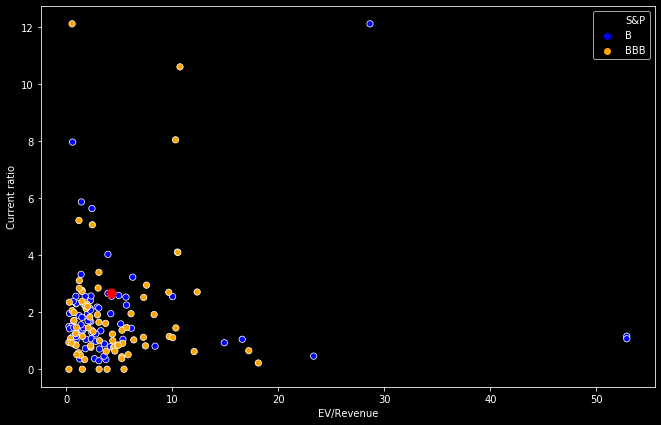

In [493]:
# Visualize scatterplot
plt.figure(figsize=(11,7))
plt.style.use("dark_background")

g = sns.scatterplot(x='EV/Revenue', y='Current ratio', hue='S&P', 
                    data=df_BBBandB, s=40, palette=['blue','orange'])

# Some random point we want to classify
plt.scatter(4.2, 2.66, marker='o', s=80, color='red')

To build this model we are going to use sklearn which is a popular machine learning software.  Let's begin by importing KNeighborsClassifier, train_test_split, and accuracy_score libraries.

#### Scikit learn library - k-NN
#### sklearn.neighbors.KNeighborsClassifier

In [494]:
from sklearn.neighbors import KNeighborsClassifier
# Split arrays or matrices into random train and test subsets
from sklearn.model_selection import train_test_split
# Computes accuracy of the algorithm on the test data 
from sklearn.metrics import accuracy_score

#### Use EV/Revenue and the Current Ratio to predict Bond S&P Ratings 
Here is a list of steps we will follow. 

#### 1. Define attributes (independent) and labels (dependent)
We will first define dependent and independent variables. Independent variables are called features and are sometimes referred to as attributes. The dependent variable is the output; or in other words, what we are attempting to predict. In our example, the independent variables are EV/Revenue and the Current Ratio while the dependent variable, or the target, is the S&P rating.

#### 2. Split data into train and test
Then, we split the data into train and test. This is absolutely necessary to avoid overfitting. It allows you to see how good the model is and how well it performs on the new test data we feed into it.

#### 3. Train the model
In part three, we train our model. 

#### 4. Make a prediction
Then make the prediction using the model we learned in the train phase.  The prediction is done on the unlabeled test data.

#### 5. Evaluate accuracy of the prediction
After we made the prediction, we must evaluate the accuracy of the algorithm. In the classification setting of k-NN, we are going to use the accuracy metric.

Let's define our independent variables, or features, by the name X and the target variable by the name Y.  We pass X and Y into the train_test_split in order to split this data randomly 70/30. This means 70% of the data goes to the training phase and 30% of the data goes to the testing phase.

We can visualize the size of the data as well as the splits between X_train, X_test, y_train, and y_test.

In [495]:
# Create features or independent variables
X = df_BBBandB[['EV/Revenue','Current ratio']]
# Our target or dependent variable
y = df_BBBandB['S&P']
# Create test and train data sets, split data randomly into 30% test and 70% train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2)

In [496]:
X_train.head(3)

,EV/Revenue,Current ratio
1240,2.00,2.20
1958,5.12,1.59
4754,0.94,2.32


In [497]:
y_test.head(3)

5555      B
1155      B
3296    BBB
Name: S&P, dtype: object

In [498]:
# 70% train, 30% test
print("X_train size =",X_train.shape[0])
print("X_test size  = ",X_test.shape[0])
print("y_test size  = ",y_test.shape[0])
print("y_train size = ",y_train.shape[0])

X_train size = 105
X_test size  =  45
y_test size  =  45
y_train size =  105


Then, we follow our steps.

We first initialize the algorithm k-NN. Next, we fit, or train, the algorithm. Then we make the prediction. Finally, we calculate the accuracy score by using the accuracy_score function from scikit-learn.

In [499]:
# Initialize knn model
knn = KNeighborsClassifier()
# train knn algorithm on training data
knn.fit(X_train, y_train)
# Predict dependent variable,Rating using test data
predictions = knn.predict(X_test)
# Compute accuracy 
accuracy = accuracy_score(y_test, predictions)

print('Accuracy: {:.2f}'.format(accuracy))

Accuracy: 0.69


In [500]:
# Visualize misclassified data
pred = pd.Series(predictions, index = y_test.index, name = 'Predicted')
pred_and_actual = pd.concat([y_test, pred], axis = 1)
pred_and_actual['Misclassified'] = pred_and_actual['S&P'] != pred_and_actual['Predicted']
pred_and_actual[pred_and_actual['Misclassified'] == True].head(5)

,S&P,Predicted,Misclassified
3296,BBB,B,True
3383,B,BBB,True
4022,B,BBB,True
5855,B,BBB,True
825,BBB,B,True


Accuracy is easy to calculate : number of ratings classified correctly / length of test data

In [501]:
correctly_predicted = pred_and_actual[pred_and_actual['Misclassified'] != True].shape[0]
#Accuracy
print(round((correctly_predicted / len(y_test)), 2))

0.69


In [502]:
# First misclassified bond
misclassified_bond = pred_and_actual[pred_and_actual['Misclassified'] == True].index[0]

In [503]:
# Fundamentals of the misclassified bond
df_ratings.loc[misclassified_bond][['EV/Revenue','Current ratio']]

EV/Revenue       2.06
Current ratio    1.45
Name: 3296, dtype: object

We can see that the accuracy score here seems ok, at least for the out of the box method.  But as you recall parameter k, which is the number of nearest points we're going to take into consideration when making our prediction, is crucial.  Whatever k that we pick is going to have a huge influence on the accuracy and the predictive power of k-NN.

The method of finding k is pretty simple.  We train our model with different k values.  We calculate the accuracy for each number of neighbors and then see which k yields the highest accuracy.  This is best visualized in a plot.

#### Finding optimal k

Here we create two lists for train accuracy and test accuracy.  We then split our data into train and test.  Then, we train our k-NN classifier for our range of values of k.  Next, we plot train accuracy and test accuracy for each number of nearest neighbors.  In this example, we will plot for our range of k's 1 through 15.  The default value for k in k-NN is 5.

One thing to remember is that when you select a small value for k, like 1 in the train data, it will severely overfit the data as you can see in the graph.  The accuracy is very high in the train data when k is equal to 1.  However, the algorithm performs poorly on the test data as defined by the blue line when k is equal to 1.  This is because the model captures all the nuances in the train data when k is equal to 1, but the model fails to generalize to the new data.  We call this low bias and high variance.

A large value for k will over simplify the model or underfit.  This is an example of high bias and low variance.

#### In k-NN Classifier, default number of neighbors = 5
#### Strategy for finding k: try different values for k and plot k vs the results of the performance metric

In [504]:
# Create lists to capture train and test accuracy values
train_accuracy = []
test_accuracy = []

# Split date into train and test, set random_state = 2 so test/train data is same as above 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2)

# Loop over values of k
for k in np.arange(1, 16):
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    train_accuracy.append(knn.score(X_train, y_train))
    test_accuracy.append(knn.score(X_test, y_test))
    
#Plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(1,16), y=test_accuracy, name='Test Accuracy'))
fig.add_trace(go.Scatter(x=np.arange(1,16), y=train_accuracy, name='Train Accuracy'))

fig.update_layout(template='plotly_dark', xaxis_title="K neighbors",
                  title='Accuracy for different k values',
                  yaxis_title='Accuracy')
fig.show(width=600, height=600)

#### Improving performance of k-NN - Feature Scaling
#### Optimal k = 5, which gives an accuracy of 0.69, but can we do better ?

Can we do better than this? Since we are just looking around for the most similar points in the neighborhood, defined by k, and are using Euclidean distance, the magnitude of features, or the variables, that we feed into the model will have an impact on performance. So if features vary by magnitude, then the algorithm will be bias toward variables with higher magnitude. To remedy this issue, we need to transform our data.

There are two common transformation methods. The first is normalization, which rescales values so they are in a range from 0 to 1. Standardization is another method that subtracts the mean from each value and divides this by the standard deviation of values. Normalization is also called Min-Max scaling, which is what we will use in this example.

#### In k-NN, numerical features should have the same scale.

In [505]:
# Generate descriptive statistics
df_BBBandB[['EV/Revenue','Current ratio']].describe()

,EV/Revenue,Current ratio
count,150.000000,150.000000
mean,4.640067,1.913800
std,7.115433,1.902742
min,0.230000,0.000000
25%,1.325000,0.912500
50%,2.420000,1.450000
75%,5.220000,2.297500
max,52.860000,12.120000


As you can see, EV/Revenue and the Current Ratio have somewhat different scales.  This can be seen by looking at the max, min, and standard deviation values.  Let's try to even out their magnitude.  We subtract the min from each value and then divide each value by the difference between max and min.

Alternatively, scikit-learn has a function that takes in a dataframe of features X and returns a normalized array which can then be used in our algorithm.

#### Normalization - rescaling values in data into [0,1] range

In [506]:
# Normalize by hand 
X = df_BBBandB[['EV/Revenue','Current ratio']]
y = df_BBBandB[['S&P']]

X_norm = (X - X.min()) / (X.max() - X.min())

df_norm = pd.concat([X_norm, y], axis = 1)

Let's plot our newly normalized data in a scatter plot format.  We can see that the values of the normalized data are slightly more even and not as spread out in terms of scale.

(0, 0.3)

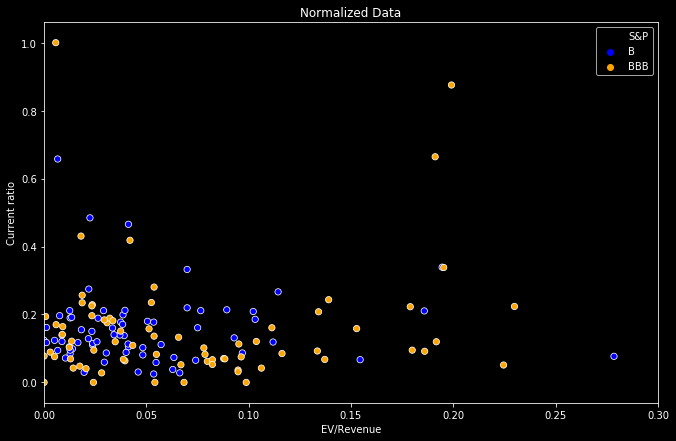

In [507]:
# Visualize scatter plot after normalization
plt.figure(figsize = (11,7))
plt.style.use("dark_background")

plt.title("Normalized Data")

g = sns.scatterplot(x='EV/Revenue', y='Current ratio', hue='S&P', 
                    data=df_norm, s=40,palette=['blue','orange'])

plt.xlim(0,0.3)

Let's train our model using new normalized data.  We use sklearn.preprocessing.MinMaxScaler to transform our data.  Then we train our model, make a prediction, and view the accuracy.

#### Use sklearn.preprocessing.MinMaxScaler to scale features to [0,1] range

In [508]:
# Recall our features and categorical value
X = df_BBBandB[['EV/Revenue','Current ratio']]
y = df_BBBandB['S&P']

# Import Scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Normalize all features
X_normalized = scaler.fit_transform(X)
# Split normalized data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size = 0.3, 
                                            random_state = 2)

In [509]:
# Use previous optimal k or set n_neighbors to defualt for now
knn = KNeighborsClassifier()

knn.fit(X_train, y_train.values.ravel())

predictions = knn.predict(X_test)

accuracy = accuracy_score(y_test, predictions)

print('Accuracy: {:.2f}'.format(accuracy))

Accuracy: 0.58


As you recall, the default value for k in k-NN is equal to 5, so let's see how the algorithm performs using the new normalized data for the range of k values 1 thourgh 15. To do this we plot the accuracy values for train and test for the range of k values 1 thourgh 15.

With the higher number of neighbors, the model tends to be generalized, or more simplified. It is up to you to determine the optimal value for k. Keep in mind that we are taking a random sample of the data, so results may vary.

In [510]:
# Let's find k
train_accuracy = []
test_accuracy = []
for k in np.arange(1,16):
    
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train.values.ravel())
    train_accuracy.append(knn.score(X_train, y_train))
    test_accuracy.append(knn.score(X_test, y_test))
    
#Plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(1,16), y=test_accuracy, name='Test Accuracy'))
fig.add_trace(go.Scatter(x=np.arange(1,20), y=train_accuracy, name='Train Accuracy'))

fig.update_layout(template='plotly_dark', xaxis_title="K neighbors", title='Accuracy for different k values',
                  yaxis_title="Accuracy")

fig.show(width=600, height=600)

#### Visualizing Probabilities for each class
Another interesting feature of k-NN is that we can visualize probabilities of each class. This means you can also think of it as a probabilistic decision model (sort of).

Here we create a mesh grid, train the model, and instead of predicting categories, we predict probabilities. We use KNeighborsClassifier.predict_proba. Dark blue regions represent high probability a bond is rated BBB, whereas dark red represents low probability a bond is rated BBB.

Z is the probability that corresponding x and y values are categorized as BBB.

#### KNeighborsClassifier.predict_proba() returns probability estimates for the test data X

In [511]:
mesh_size = .02
margin = 0.0

# Split our data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size = .3, random_state = 4)

# Create a mesh grid on which we will run our model
X = X_normalized.copy()
x_min, x_max = X[:, 0].min() - margin, X[:, 0].max() + margin
y_min, y_max = X[:, 1].min() - margin, X[:, 1].max() + margin
xrange = np.arange(x_min, x_max, mesh_size)
yrange = np.arange(y_min, y_max, mesh_size)
xx, yy = np.meshgrid(xrange, yrange)

# Fit KNN on the train data
knn.fit(X_train, y_train.values.ravel())

# Predict probabilities
Z = knn.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

# Plot figure
fig = go.Figure(data = [go.Contour(x=xrange, y=yrange, z=Z, colorscale='RdBu')])

fig.update_layout(template='plotly_dark', xaxis_title="EV/Revenue", title='Probability Estimates',
                  yaxis_title="Current ratio")

fig.show()

Looking at the scatter plot created earlier after normalization, the region in the lower right has the majority of the BBB rated bonds.  The probability that a bond is rated BBB in this region is higher.  Conversely, the left region of the scatter plot has the majority of B rated bonds.  The probability that a bond is rated BBB is lower in this region and is why the probability graph shades this region red.

(0, 0.3)

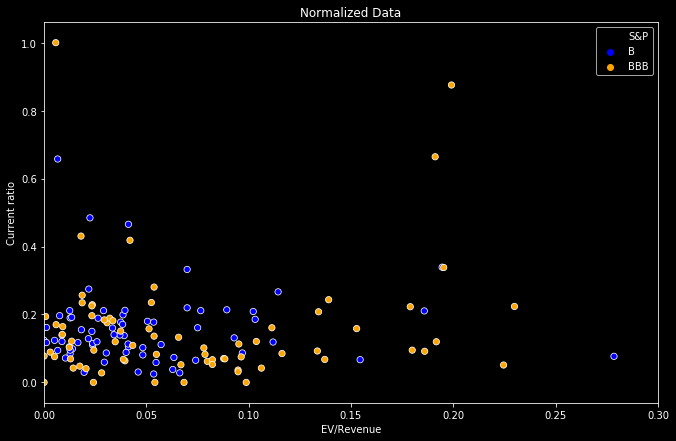

In [512]:
# Visualize scatter plot after normalization
plt.figure(figsize = (11,7))
plt.style.use("dark_background")

plt.title("Normalized Data")

g = sns.scatterplot(x='EV/Revenue', y='Current ratio', hue='S&P', 
                    data=df_norm, s=40,palette=['blue','orange'])

plt.xlim(0,0.3)

On your own, try classifying B and BBB using all features (not just EV/Revenue and Current ratio). You should see accuracy increase with the introduction of
more variables.

### Apply k-NN on a larger subset of credit data

#### Increase number of classes and features
Now that we have developed an intuition for our workflow, let's give k-NN a more difficult task.  Often when applying k-NN to financial applications, the data may have more categories and more features that can be used to make predictions.

In this example, we are going to expand our features.  We are also going to increase the number of categories we are trying to predict so that BB rated bonds are included.  We will predict if a bond is rated either BBB, BB, or B.

In [513]:
# Visualize our dataset
df_ratings.head(3)

,Issuer Name,Symbol,Callable,Sub-Product Type,Coupon,Maturity,Moody's®,S&P,Price,Yield,Maturity Years,Duration,Operating Margin,Current ratio,EV/Revenue,Return on Assets,Return on Equity
6324,XEROX HLDGS CORP,XPO,Yes,Corporate Bond,0.0675,08/15/2024,Ba3,B,103.420,0.02530,3.019444,0.187830,0.0528,1.02,0.90,0.0395,0.1792
2285,FORESTAR GROUP INC,DHI,Yes,Corporate Bond,0.0500,03/01/2028,B1,B,104.055,0.03839,6.613889,0.858466,0.1806,5.87,1.41,0.1480,0.2889
891,CHURCHILL DOWNS INC,CHDN,Yes,Corporate Bond,0.0550,04/01/2027,B1,B,103.884,0.03472,5.683333,0.701377,0.1828,1.44,6.12,0.0538,0.6371


In [514]:
# Columns from the data set 
features = ['Current ratio', 'Operating Margin', 'Return on Assets', 'EV/Revenue']

# Numerical features or independent variables
X = df_ratings[features]

# Dependent variable, B, BB & BBB
y = df_ratings['S&P']

In [515]:
y.value_counts()

B      75
BB     75
BBB    75
Name: S&P, dtype: int64

#### 1. Normalize features
First we normalize the data.  

#### 2. Split data into train and test
We then split the data into train and test again.

#### 3. Train k-NN algorithm on numerical columns
We train our model.

#### 4. Predict 
Then we make our prediction on the test data and compute the accuracy score.

#### 5. Evaluate accuracy of the prediction
After we made the prediction, we must evaluate the accuracy of the algorithm.

In [516]:
# Normalize independent cols of data
X_normalized = scaler.fit_transform(X)
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size = 0.3, random_state = 2)

# Initialize model
knn = KNeighborsClassifier()
# Train
knn.fit(X_train, y_train)
# Predict
predictions = knn.predict(X_test)
# Compute accuracy
accuracy = accuracy_score(y_test, predictions)
print('Accuracy: {:.2f}'.format(accuracy))

Accuracy: 0.43


Let's visualize our accuracy for a range of k values.

In [517]:
# Try different values for k
train_accuracy = []
test_accuracy = []

for k in np.arange(1,16):
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    train_accuracy.append(knn.score(X_train, y_train))
    test_accuracy.append(knn.score(X_test, y_test))
    
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(1,16), y=test_accuracy, name='Test Accuracy'))
fig.add_trace(go.Scatter(x=np.arange(1,16), y=train_accuracy, name='Train Accuracy'))

fig.update_layout(template='plotly_dark', xaxis_title="K neighbors", title='Accuracy for different k values',
                  yaxis_title="Accuracy")

fig.show(width=600, height=600)

One potential reason for the decrease in the accuracy is the introduction of a new category BB. Features, like fundamental data, are now more likely to overlap between BB and the original values of BBB and B.

Other potential reasons for the decrease in accuracy is that we are either not using the correct features or k-NN is not the correct model to use in this instance. For example, k-NN is often used as a baseline model to help measure more complex algorithms like support vector machines (SVM) and neural networks (NN).

## k-NN for regression

For the last example, let's look at k-NN in a regression setting.  Although k-NN is more commonly used in classification, it is worth taking a look at how k-NN can be applied in a regression.  Recall that in a regression test, we predict continuous values while in a classification test we predict categories or labels.  We will use sklearn.neighbors.KNeighborsRegressor and use the same features in the data, but we will change the dependent value to Yield.

As you recall in the classification example, we calculated the distance between the test point and all the points.  Then, we got the closest k neighbors and sorted by distance.  If the k equals 3, like in our theory section where we were looking at the triangles and squares, and there were two triangles and one square, then we would classify a new point as a triangle.

In a regression setting, where the values we are trying to calculate are numeric, all we have to do is take the average or the mean of the k nearest neighbors.  If we have k equal to 3, we just take the average of the 3 closest points to come up with our prediction.

Let's again follow the steps now that we have defined our X and Y values.

#### 1. We normalized the data.
#### 2. We split data into train and test.
#### 3. We train the algorithm.
#### 4. We make a prediction.
#### 5. We evaluate the accuracy of the prediction.

#### sklearn.neighbors.KNeighborsRegressor

In [518]:
# Import KNN regressor 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# Keep the same columns as features
features = ['Current ratio', 'Operating Margin', 'Return on Assets', 'EV/Revenue']

y = df_ratings['Yield']
X = df_ratings[features]

# Normalize data
X_normalized = scaler.fit_transform(X)

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size = 0.3, 
                                                    random_state = 2)
# Initialize model
knn = KNeighborsRegressor()

# train
knn.fit(X_train, y_train)
# Predict
predictions = knn.predict(X_test)

But how do we go about evaluating the result? The accuracy metric that we used before no longer makes sense for this type of problem. This is where root-mean-square error (RMSE) is useful. RMSE is a standard way to measure the error of a model that has tried to predict numerical or quantitative data.

<h4>Root Mean Square Error (RMSE) measures the error in numerical predictions</h4>  
<img src='img/rmse.jpg'>

#### predicted(i) - predicted value for the ith observation
#### actual(i) - observed (true) data
#### N - total number of observations

As we can see from the formula, we can think of this as the normalized distance between actual value and the value the model predicted. We then sum the differences between the actual value and the predicted value and then find the average by dividing the result by the number of observations. This is done so that the units of our error match the units of the value we are trying to predict, which only requires us to take the square root of the value.

In our example, we plug in both the model's predictions and y-test into mean_squared_error we imported from scikit-learn. The result will show us how many decimal format percentage points we deviate on average from the true Yield (e.g. 0.01 = 1%).

In [519]:
RMSE = math.sqrt(mean_squared_error(y_test, predictions))

print('Root Mean Square Error: {:.4f}'.format(RMSE))

Root Mean Square Error: 0.0146


Note that RMSE is in the same units as the value we are trying to predict
so in our case, the error is in decimal format of percent (e.g. 0.01 = 1%).

To find the optimal value of k, we plot RMSE versus k values. In this case, we are looking for the k value that will result in the lowest RMSE.

In [520]:
# Plot RMSE for values of k to see which k minimizes the error
rmse_value = []

for k in np.arange(1,16):
    
    knn = KNeighborsRegressor(n_neighbors = k)
    knn.fit(X_train, y_train)
    pred = knn.predict(X_test)
    error = math.sqrt(mean_squared_error(y_test, pred))
    rmse_value.append(error)
    
#Plot only for test set
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(1,16), y=rmse_value, name='Test Accuracy'))
#fig.add_trace(go.Scatter(x=np.arange(1,20),y = train_accuracy, name = 'Train Accuracy'))

fig.update_layout(template='plotly_dark', xaxis_title="K neighbors", title='RMSE for different k values',
                  yaxis_title="RMSE")

fig.show(width=600, height=600)

So now we have seen how k-NN can be applied in a regression setting. Based on this example, it is pretty clear that k-NN might not be the best model when it comes to predicting Yield.

What may be the reasons for such poor model performance? One reason may be that the variables selected may not contain much predictive power when it comes to predicting Yield. Also, recall what k-NN does in a regression setting. It takes the average of the k nearest neighbors. So essentially, it takes the average of the closest Yields, which likely vary significantly even for bonds that share similar fundamental characteristics.

## Summary of what we learned about k-NN.

The k-NN algorithm is not parametric, so it makes no assumptions about the underlying data.  As the above examples show, k-NN is an easy algorithm to implement and very intuitive to understand.  We also learned that k-NN works for both regression and classification, although the algorithm tends to be used for classification more frequently in practice.

Some negatives associated with k-NN is that it can be sensitive to outliers and the magnitude of the features.  This must be taken into consideration and is why preprocessing of features should be done before passing them to the algorithm.  Because the model must store all the data to calculate the distances, k-NN uses a lot of memory.  As the dataset grows, the speed of the k-NN algorithm will decline.

## Additional Resources




### k-NN from scratch

#### 1. Euclidean Distance
#### 2. Locate neighbors
#### 3. Make Predictions

In [521]:
#Filter our data for BBB & B ratings only
df_BBBandB = df_ratings[df_ratings['S&P'].isin(['BBB','B'])]
df_BBBandB.head(3)

,Issuer Name,Symbol,Callable,Sub-Product Type,Coupon,Maturity,Moody's®,S&P,Price,Yield,Maturity Years,Duration,Operating Margin,Current ratio,EV/Revenue,Return on Assets,Return on Equity
6324,XEROX HLDGS CORP,XPO,Yes,Corporate Bond,0.0675,08/15/2024,Ba3,B,103.420,0.02530,3.019444,0.187830,0.0528,1.02,0.90,0.0395,0.1792
2285,FORESTAR GROUP INC,DHI,Yes,Corporate Bond,0.0500,03/01/2028,B1,B,104.055,0.03839,6.613889,0.858466,0.1806,5.87,1.41,0.1480,0.2889
891,CHURCHILL DOWNS INC,CHDN,Yes,Corporate Bond,0.0550,04/01/2027,B1,B,103.884,0.03472,5.683333,0.701377,0.1828,1.44,6.12,0.0538,0.6371


In [522]:
# Convert data to numpy array
test_data = df_BBBandB[['EV/Revenue','Current ratio','S&P']].to_numpy()

1. Calculate Euclidean distance between two vectors

In [523]:
def euclidean_distance(point1, point2):
    sum_squared_distance = 0
    for i in range(len(point1) - 1):
        sum_squared_distance += math.pow(point1[i] - point2[i], 2)
    return math.sqrt(sum_squared_distance)


Visualize 1st row in a test_data

In [524]:
# 1st row in the test_data
test_row = test_data[5]
test_row

array([1.19, 1.88, 'B'], dtype=object)

2. Get k nearest neighbors

In [525]:
def locate_neighbors(train, test_row, k):
    distances = []
    for train_row in train:
        dist = euclidean_distance(test_row, train_row)
        distances.append((train_row, dist))
    distances.sort(key = lambda tup : tup[1])
    neighbors = []
    for i in range(k):
        neighbors.append(distances[i][0])
    return neighbors

3. Predict

In [526]:
def make_prediction(train, test_row, k):
    neighbors = locate_neighbors(train, test_row , k)
    output = [row[-1] for row in neighbors]
    prediction = max(set(output), key = output.count)
    return prediction

In [527]:
prediction = make_prediction(test_data, test_row, 3)
print( "Expected:", test_data[0][-1], 'Predicted:', prediction)

Expected: B Predicted: B


#### Python Libraries

Scikit train_test_split:
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

Scikit k-NN:
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
    
Scikit k-NN Regressor: 
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor

Scikit Normalization:
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

    
    
#### Helpful Blog Posts

Machine Learning for Investing:
https://hdonnelly6.medium.com/list/machine-learning-for-investing-7f2690bb1826

A Complete Machine Learning Project Walk-Through in Python:
https://towardsdatascience.com/a-complete-machine-learning-walk-through-in-python-part-one-c62152f39420

k-NN from Scratch:
https://machinelearningmastery.com/tutorial-to-implement-k-nearest-neighbors-in-python-from-scratch/

Normalization vs Standardization:
https://towardsdatascience.com/normalization-vs-standardization-quantitative-analysis-a91e8a79cebf
    
A Practical Introduction:
https://www.analyticsvidhya.com/blog/2018/08/k-nearest-neighbor-introduction-regression-python/